In [16]:
import json

import pandas as pd
import numpy as np
import networkx as nx

import torch
from torch_geometric.nn import GATv2Conv, global_max_pool
from torch_geometric.data import Data
from torch_geometric.loader import GraphSAINTRandomWalkSampler, GraphSAINTNodeSampler
from matplotlib import pyplot as plt

from train_utils import *
from product_graph import *
from tqdm.notebook import tqdm
from torch_geometric.utils import to_dense_adj
from torch.nn import MSELoss
from product_graph import generate_parametric_product_graph
import networkx as nx
from torch_geometric.utils import from_networkx
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.utils import from_scipy_sparse_matrix
from sklearn.preprocessing import StandardScaler
import os
from sklearn.metrics import mean_absolute_error, r2_score

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
class GATv3Conv(torch.nn.Module):
    def __init__(self, in_channels, out_channels, concat = True, heads=1) -> None:
        super().__init__()
        self.beta = torch.nn.Parameter(torch.tensor(0.5))
        self.conv = GATv2Conv(in_channels, out_channels, heads, concat, add_self_loops=False)

    def forward(self, x, edge_index, edge_weights):
        H, C = self.conv.heads, self.conv.out_channels

        if isinstance(x, torch.Tensor):
            assert x.dim() == 2
            x_l = self.conv.lin_l(x).view(-1, H, C)
            if self.conv.share_weights:
                x_r = x_l
            else:
                x_r = self.conv.lin_r(x).view(-1, H, C)
        else:
            raise TypeError("x must be a Tensor")

        assert x_l is not None
        assert x_r is not None

        # edge_updater_type: (x: PairTensor, edge_attr: OptTensor)
        alpha = self.conv.edge_updater(edge_index, x=(x_l, x_r), edge_attr=None)
        
        alpha = (1-self.beta) * alpha + self.beta * edge_weights.view(edge_weights.shape[0],1)
        # propagate_type: (x: PairTensor, alpha: Tensor)
        out = self.conv.propagate(edge_index, x=(x_l, x_r), alpha=alpha)

        if self.conv.concat:
            out = out.view(-1, self.conv.heads * self.conv.out_channels)
        else:
            out = out.mean(dim=1)

        if self.conv.bias is not None:
            out = out + self.conv.bias

        return out
    

class GATNN(torch.nn.Module):
    def __init__(self, in_dim, hidden_size, out_dim, in_head=8, out_head=1, p=0.25) -> None:
        super().__init__()
        self.hid = hidden_size
        self.in_head = in_head
        self.out_head = out_head
        self.p = p
        
        self.conv1 = GATv3Conv(in_channels=in_dim, 
                               out_channels=self.hid, 
                               heads=self.in_head)
        
        self.conv2 = GATv3Conv(in_channels=self.hid*self.in_head, 
                               out_channels=self.hid, 
                               heads=self.out_head, 
                               concat=False)
        
        self.lin = nn.Linear(self.hid, out_dim)

    def forward(self, x, edge_index, edge_weight):
        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, p=self.p, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        
        batch = torch.zeros(x.size(0), dtype=torch.long)
        x = global_max_pool(x, batch, size=x.shape[0]//4)

        x = self.lin(x)
        return x

In [4]:
dynamic_data = torch.tensor(np.load("data/preprocessed/dynamic_data.npy", allow_pickle=True))
S = torch.tensor(np.load("data/adjacency/coords_features.npy", allow_pickle=False))
scaler = StandardScaler()
data_normalized = scaler.fit_transform(dynamic_data)

data = create_forecasting_dataset(data_normalized.T,
                                      splits = [0.8, 0.1, 0.1],
                                      pred_horizen= 1,
                                      obs_window= 4,
                                      verbose = 0)
edge_index = torch.nonzero(torch.tensor(S), as_tuple=False).t().contiguous()
edge_weight = S[edge_index[0], edge_index[1]]

criterion = MSELoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GATNN(in_dim=1, hidden_size=32, out_dim=1)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)

temporal_adj = np.array([[0, 0, 0, 0],
                [1, 0, 0, 0],
                [0, 1, 0, 0],
                [0, 0, 1, 0]])

C:\Users\Primakov Chungkham\AppData\Local\Temp\ipykernel_32232\2269948961.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.nonzero(torch.tensor(S), as_tuple=False).t().contiguous()


In [5]:

# loop over the number of samples
train_samples = data['trn']['data'].shape[0]
val_samples = data['val']['data'].shape[0]
train_losses = []
val_losses = []

patience = 5
best_val_loss = float('inf')
counter = 0
flag = False

for epoch in range(20):
    total_loss = 0
    for i in range(train_samples):
        # Create a torch geometric data over each graph 
        outer_batch = Data(x = torch.tensor(data['trn']['data'][i]), y = torch.tensor(data['trn']['labels'][i].squeeze()),
                        edge_index=edge_index, edge_weight = edge_weight) 
        
        train_loader = GraphSAINTNodeSampler(outer_batch, batch_size=100, num_steps=6)
        for inner_batch in train_loader:
            model.train()
            batch_loss = 0
            batch_adj = to_dense_adj(inner_batch.edge_index, edge_attr=inner_batch.edge_weight).squeeze(dim = 0)
            
            batch_adj = batch_adj.numpy()
            
            product_graph = generate_parametric_product_graph(s00 = 0, s01 = 1, s10 = 1, s11 = 1, A_T = temporal_adj, A_N = batch_adj, spatial_graph = None)
            product_edge_index, product_edge_weight = from_scipy_sparse_matrix(product_graph)
            
            
            batch_x =inner_batch.x.reshape(inner_batch.x.shape[0]* inner_batch.x.shape[1], 1)
            
            batch_y = inner_batch.y.unsqueeze(dim = 1)
            optimizer.zero_grad()
            out = model(batch_x.float(), product_edge_index,product_edge_weight.float())
            loss = criterion(out, batch_y.float())
            batch_loss += loss
        
            loss.backward()
            optimizer.step()
            total_loss += batch_loss
        
    train_losses.append((total_loss/ (len(train_loader) * train_samples)).detach().numpy())
    val_loss = 0
    for i in range(val_samples):
        model.eval()
        # Create a torch geometric data over each graph 
        outer_batch = Data(x = torch.tensor(data['val']['data'][i]), y = torch.tensor(data['val']['labels'][i].squeeze()),
                        edge_index=edge_index, edge_weight = edge_weight) 
        
        val_loader = GraphSAINTNodeSampler(outer_batch, batch_size=200, num_steps=6)
        for val_batch in val_loader:
            with torch.no_grad():
                batch_loss = 0
                batch_adj = to_dense_adj(val_batch.edge_index, edge_attr=val_batch.edge_weight).squeeze(dim = 0)
                
                batch_adj = batch_adj.numpy()
                
                product_graph = generate_parametric_product_graph(s00 = 0, s01 = 1, s10 = 1, s11 = 1, A_T = temporal_adj, A_N = batch_adj, spatial_graph = None)
                product_edge_index, product_edge_weight = from_scipy_sparse_matrix(product_graph)
                
                
                batch_x =val_batch.x.reshape(val_batch.x.shape[0]* val_batch.x.shape[1], 1)
                
                batch_y = val_batch.y.unsqueeze(dim = 1)
                out = model(batch_x.float(), product_edge_index,product_edge_weight.float())

                batch_val_loss = criterion(out, batch_y.float())

                val_loss += batch_val_loss
                
    val_losses.append(val_loss/(len(val_loader) * val_samples))
    print(f'Epoch: {epoch+1}, Training Loss: {total_loss/ (len(train_loader) * train_samples)}, Validation Loss: {val_loss/(len(val_loader) * val_samples)}')
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1
    if counter >= patience:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'best_val_loss': best_val_loss,
            'train_losses': train_losses,
            'val_losses': val_losses,
        }, f'model_epoch_{epoch}.pt')
        flag = True
        break
    
if flag == False:
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'best_val_loss': best_val_loss,
        'train_losses': train_losses,
        'val_losses': val_losses,
    }, f'model_trained.pt')
    
        
        


Epoch: 1, Training Loss: 1.0575873851776123, Validation Loss: 1.132115364074707
Epoch: 2, Training Loss: 1.0766334533691406, Validation Loss: 1.0312391519546509
Epoch: 3, Training Loss: 1.0704065561294556, Validation Loss: 1.1095150709152222
Epoch: 4, Training Loss: 1.058449625968933, Validation Loss: 1.0900557041168213
Epoch: 5, Training Loss: 1.046744704246521, Validation Loss: 0.9586216807365417
Epoch: 6, Training Loss: 1.1485084295272827, Validation Loss: 1.175473928451538
Epoch: 7, Training Loss: 1.095755696296692, Validation Loss: 1.1147983074188232
Epoch: 8, Training Loss: 1.169656753540039, Validation Loss: 1.1209092140197754
Epoch: 9, Training Loss: 1.0996662378311157, Validation Loss: 1.078750729560852
Epoch: 10, Training Loss: 1.0422900915145874, Validation Loss: 1.1028469800949097


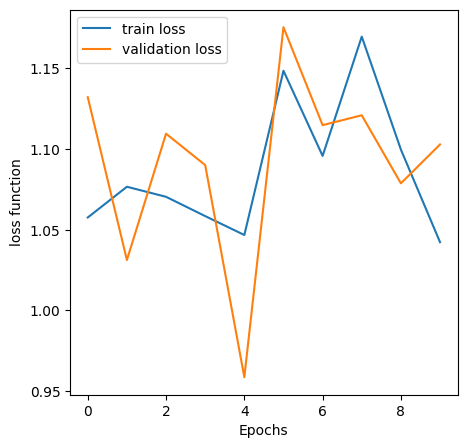

In [7]:
plt.figure(figsize = (5,5))
plt.xlabel("Epochs")
plt.ylabel("loss function")
plt.plot(train_losses, label = "train loss")
plt.plot(val_losses, label = "validation loss")
plt.legend()
plt.show()

### Inference code

##### Uncomment this code if you need to load your model

In [8]:
# model = GATNN(in_dim=1, hidden_size=32, out_dim=1)
# state_dict = torch.load('model_epoch_6.pth')
# model.load_state_dict(state_dict)

In [15]:
test_loss = 0
test_samples = data['tst']['data'].shape[0]
predicted_samples = []
true_samples = []
for i in range(test_samples):
    model.eval()
    # Create a torch geometric data over each graph 
    outer_batch = Data(x = torch.tensor(data['val']['data'][i]), y = torch.tensor(data['val']['labels'][i].squeeze()),
                    edge_index=edge_index, edge_weight = edge_weight) 
    
    test_loader = GraphSAINTNodeSampler(outer_batch, batch_size=200, num_steps=6)
    for test_batch in test_loader:
        with torch.no_grad():
            batch_loss = 0
            batch_adj = to_dense_adj(test_batch.edge_index, edge_attr=test_batch.edge_weight).squeeze(dim = 0)
            
            batch_adj = batch_adj.numpy()
            
            product_graph = generate_parametric_product_graph(s00 = 0, s01 = 1, s10 = 1, s11 = 1, A_T = temporal_adj, A_N = batch_adj, spatial_graph = None)
            product_edge_index, product_edge_weight = from_scipy_sparse_matrix(product_graph)
            
            
            batch_x =test_batch.x.reshape(test_batch.x.shape[0]* test_batch.x.shape[1], 1)
            
            batch_y = test_batch.y.unsqueeze(dim = 1)
            out = model(batch_x.float(), product_edge_index,product_edge_weight.float())

            true_samples.extend(batch_y)
            predicted_samples.extend(out)

            #print(out.shape, batch_y.shape)

            batch_test_loss = criterion(out, batch_y.float())

            test_loss += batch_test_loss
                
print(f'Test Loss per Batch: {test_loss/(len(test_loader) * test_samples)}')

Test Loss per Batch: 1.0221514701843262


In [19]:
print(f"The r2 score value is: {r2_score(true_samples, predicted_samples)}")

The r2 score value is: 0.0018338640242008264


In [20]:
print(f"The mean absolute error is: {mean_absolute_error(true_samples, predicted_samples)}")

The mean absolute error is: 0.6216435240692016
